# Fluvial Representative Subset of Events

__Description__:

__Input__: 

__Output__: 

---
## Load Libraries, Parameters, and Data:
### Libraries:

In [1]:
import os
import json
import shutil
import numpy as np
import pandas as pd
import pathlib as pl
from matplotlib import pyplot as plt

### Parameters:
#### Site specific:

In [2]:
Project_Area = 'Sacramento'
Fluvial_Model = 'F02'         # Pluvial model name
Domain = 'D01'
mainBCN = 'F02'

#root_dir = pl.Path(os.getcwd())
root_dir = pl.Path(r'C:\Users\sputnam\Desktop\PFRA_Production\Fluvial\{0}'.format(Project_Area))
outputs_dir = root_dir/'Outputs'
notebooks_dir = root_dir/'Notebooks'
forcing_dir = outputs_dir/'{0}_{1}_Forcing'.format(Project_Area, Fluvial_Model)
forcing_file = '{0}_{1}_{2}.json'.format(Project_Area, Fluvial_Model, Domain)
weight_file = '{0}_{1}_{2}_Weights.json'.format(Project_Area, Fluvial_Model, Domain)
notebook_name = 'Fluvial_Subset'

#### Project specific (global):

In [3]:
binwidth = 0.1  # [log cfs]; increment for binning the excess rainfall amount

### Data:
#### Forcing *json*:

In [4]:
with open(forcing_dir/forcing_file) as f:
    ff_dic = json.load(f)
    
bcns = list(ff_dic['Fluvial']['BCName'].keys())
print('Boundary conditions:', bcns)

Boundary conditions: ['F01', 'F02', 'F03', 'F04', 'F05', 'Q03', 'Q04', 'Q05', 'Q06', 'Q07', 'Q08', 'Q09', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'S01']


#### Weight *json*:

In [5]:
with open(outputs_dir/weight_file) as f:
    wt =  json.load(f)
    print('Total weight: ', round(sum(wt['BCName'][Domain].values()), 4))

Total weight:  0.5


---
## Calculate a Representative Subset of Events:

Simulations to include in the Global Scale Test: 10


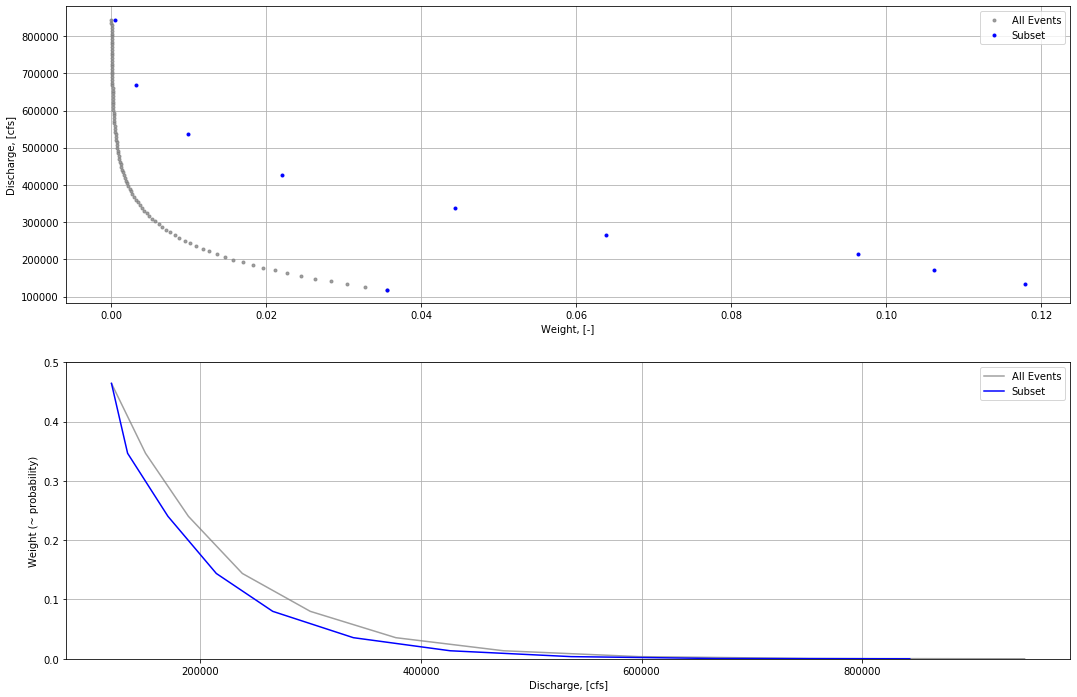

In [6]:
df = pd.DataFrame()
df['Events'] = list(wt['BCName'][Domain].keys())
df['Weight'] = list(wt['BCName'][Domain].values())    
df = df.set_index('Events')

#with open(outputs_dir/'{0}_{1}_Forcing/{0}_{1}_{2}.json'.format(Project_Area, 'F01', Domain)) as f:
#    fill_dic = json.load(f)  
#E_55 = False
#for i in df.index:
#    if i=='E0055':
#        E_55 = True
#    if E_55:
#        df.loc[i, 'Discharge'] = max(ff_dic['Fluvial']['BCName'][mainBCN][i])
#    else:    
#        df.loc[i, 'Discharge'] = max(fill_dic['Fluvial']['BCName'][mainBCN][i])
        
for k, v in ff_dic['Fluvial']['BCName'][mainBCN].items():
    df.loc[k, 'Discharge'] = max(v)
df = df.reset_index().sort_values(by=['Discharge'], ascending = True).set_index('Events')  
df['logQ'] = np.log10(df['Discharge'])

binmin = min(df['logQ'])
binmax = max(df['logQ'])
bins = np.arange(binmin, binmax+binwidth, binwidth)

lst = []

for i, b in enumerate(bins):
    if i == 0:
        weight = df[b == df['logQ']]['Weight'][0]
        qavg = b
    elif i>0 :
        weight = sum(df[(bins[i-1] < df['logQ']) & (df['logQ'] <= bins[i])]['Weight'])
        qavg = (b+bins[i-1])/2
    lst.append((b, qavg, weight))
binned  = pd.DataFrame()
binned['Discharge'] = [10**i[0] for i in lst]
binned['logQ'] = [i[0] for i in lst]
binned['logQavg'] = [i[1] for i in lst] 
binned['Weight'] = [i[2] for i in lst] 

assert 0.5 == round(sum(binned['Weight']), 2), 'Total weight does not equal 0.5 as expected'
binned['Cumulative'] = binned['Weight'].cumsum()
binned['Theoretical RI'] = 1.0/(0.5-binned['Cumulative'])

event = []

for qavg in binned['logQavg']:
    diff = df['logQ']-qavg
    event.append(diff[diff.abs().argsort()].index[0])
binned['Event'] = event    

unique_events = list(set(list(binned['Event'])))
edf = pd.DataFrame(data = {'Event': unique_events})

for i, e in enumerate(edf['Event']):
    edf.loc[i, 'Weight'] = sum(binned[binned['Event']==e]['Weight']) 
    edf.loc[i, 'Discharge'] = df.loc[e]['Discharge']
edf = edf[edf['Weight']>0.0].copy(deep=True)
assert np.round(sum(edf['Weight']), 2) == 0.5 , 'Total weight does not equal 0.5 as expected'
edf = edf.sort_values('Discharge').reset_index(drop = True)
edf['Cumulative'] = edf['Weight'].cumsum()   
print('Simulations to include in the Global Scale Test: {}'.format(edf.shape[0]))

fig, ax = plt.subplots(2, 1, figsize=(18, 12))
ax[0].plot(df['Weight'], df['Discharge'], linestyle = '', marker = '.' , label = 'All Events', color = 'gray', alpha = 0.75)
ax[0].plot(edf['Weight'], edf['Discharge'], linestyle = '', marker = '.', color = 'blue', label = 'Subset')
ax[0].set_xlabel('Weight, [-]', fontsize = 10)
ax[0].set_ylabel('Discharge, [cfs]', fontsize=10)
ax[0].legend()
ax[0].grid()    
ax[1].plot(binned['Discharge'], 0.5 - binned['Cumulative'], linestyle = '-', marker = '', label = 'All Events', color = 'gray', alpha = 0.75)
ax[1].plot(edf['Discharge'], 0.5-edf['Cumulative'], linestyle = '-', marker = '', color = 'blue', label = 'Subset')
ax[1].set_xlabel('Discharge, [cfs]', fontsize = 10)
ax[1].set_ylabel('Weight (~ probability)', fontsize=10)
ax[1].set_ylim([0, 0.5])
ax[1].legend()
ax[1].grid()   

edic = {'BCName': {Domain: {}}}

for i, e in enumerate(edf['Event']):
    edic['BCName'][Domain][e] = edf.loc[i]['Weight']
    
with open(outputs_dir/'{0}_{1}_{2}_Weights_TRI.json'.format(Project_Area, Fluvial_Model, Domain), 'w') as f:
    json.dump(edic, f)
    
df = pd.DataFrame(data = {'Events': list(edf['Event'])})
df = df.set_index('Events')
df.to_csv(outputs_dir/'{0}_{1}_{2}_Events_TRI.csv'.format(Project_Area, Fluvial_Model, Domain))  

---
## File Save Notebook and Run:

In [7]:
nb_copy = notebooks_dir/'{0}_{1}_{2}.ipynb'.format(notebook_name, Project_Area, Fluvial_Model)
shutil.copyfile(pl.Path(os.getcwd())/'{0}.ipynb'.format(notebook_name), nb_copy);
! jupyter nbconvert $nb_copy --log-level WARN

---
## End